## TODO
### Plumbing
- add 'selected' column to dataframes, discard exp16 GAL pictures
- [DONE] remove cells straddling the border (implemented, needs a rerun)
- make sure replicate colors are consistent (add pseudo-counts for absent replicate)
### Sanity checks
- compare plots with original spots and decomposed spots
- inspect cells with very high numbers of mRNAs
### Plots
- expression versus area/eccentricity
- expression versus growth rate
- plots: distance to centroid/wall/tip 

# Results

## Load data

In [710]:
from pathlib import Path
import pandas as pd
import re
import logging
import seaborn as sns
from itertools import combinations
from matplotlib import pyplot as plt
import numpy as np
from seaborn import FacetGrid
from IPython.utils import io

pd.options.display.precision = 2

In [711]:
conditions = [
    {'label': 'LB', 'mu': 2.3},
    {'label': 'GLU', 'mu': 0.54},
    {'label': 'GLY', 'mu': 0.32},
    {'label': 'GAL', 'mu': 0.17},
    {'label': 'MAN', 'mu': 0.12},
]
mrna_ordered = ['rpoD', 'hipBA', 'rnlAB']
csources_ordered = [c['label'] for c in conditions]
csources_ordered

['LB', 'GLU', 'GLY', 'GAL', 'MAN']

In [712]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s ', datefmt='%m/%d/%Y %I:%M:%S%p', level=logging.INFO)
rootdir = "/Volumes/Flodrive/Florence/smFISH/analysis"

logging.info(f'reading from directory {rootdir}')

11/16/2024 11:07:03AM [INFO] reading from directory /Volumes/Flodrive/Florence/smFISH/analysis 


In [713]:
palette_mrna = {
    'rpoD': 'magenta',
    'rnlAB': 'yellow',
    'hipBA': 'cyan',
}
palette_replicate = sns.color_palette("hls", 4)
palette_csource = sns.color_palette("viridis", as_cmap=True)

#### Stacked format
- format with 1 row per cell and per mrna
- mrna is specified in 'mrna' column
- so this df has about 3x total number of cells rows (because we have 3 rna channels)

In [714]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
# for f in Path(rootdir).glob('20241029-exp24/exp24-GLU-right-2_01/results.csv'):
    cell_df = pd.read_csv(f.parent / "cells.csv")
    for mrna in mrna_ordered:
        f_mrna = Path(str(f) + f'.{mrna}')
        logging.info(f'..loading file: {f_mrna}')
        df = pd.read_csv(f_mrna)
        df['image'] = f_mrna.parts[-2]
        df['experiment'] = f_mrna.parts[-3]
        df = df.join(cell_df.set_index('image_cell_id'), on='image_cell_id')
        dfs.append(df)
df_stacked = pd.concat(dfs)

11/16/2024 11:07:13AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rpoD 
11/16/2024 11:07:13AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.hipBA 
11/16/2024 11:07:13AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rnlAB 
11/16/2024 11:07:13AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rpoD 
11/16/2024 11:07:13AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.hipBA 
11/16/2024 11:07:13AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rnlAB 
11/16/2024 11:07:13AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv.rpoD 
11

In [715]:
df_stacked

,image_cell_id,spots,dense_regions,decomposed_RNAs,tx,nascent_RNAs,total_RNAs,mrna,strain,condition,seqnr,image,experiment,bbox-0,bbox-1,bbox-2,bbox-3,area,eccentricity,nuclei
0,531,0,0,0,0,0,0,rpoD,exp24,GLU,1,exp24-GLU-right-2_01,20241029-exp24,1,485,22,522,600.0,0.83,1
1,533,0,0,0,0,0,0,rpoD,exp24,GLU,1,exp24-GLU-right-2_01,20241029-exp24,2,891,34,925,710.0,0.83,1
2,535,0,0,0,0,0,0,rpoD,exp24,GLU,1,exp24-GLU-right-2_01,20241029-exp24,3,801,45,842,803.0,0.94,2
3,537,0,0,0,0,0,0,rpoD,exp24,GLU,1,exp24-GLU-right-2_01,20241029-exp24,7,194,43,228,672.0,0.89,2
4,540,0,0,0,0,0,0,rpoD,exp24,GLU,1,exp24-GLU-right-2_01,20241029-exp24,12,791,48,826,621.0,0.93,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,956,2,0,0,0,0,2,rnlAB,MG1655,LB_fixed2806_hybed1906_left,7,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,951,335,969,380,681.0,0.93,3
483,965,1,0,0,0,0,1,rnlAB,MG1655,LB_fixed2806_hybed1906_left,7,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,956,295,975,336,554.0,0.92,2
484,966,3,0,0,0,0,3,rnlAB,MG1655,LB_fixed2806_hybed1906_left,7,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,956,1176,986,1244,1230.0,0.96,4
485,974,1,1,2,1,2,2,rnlAB,MG1655,LB_fixed2806_hybed1906_left,7,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,960,542,985,589,800.0,0.91,2


In [716]:
pattern = re.compile(f'(?P<strain>[0-9A-Za-z]+)[_-](?P<csource>{"|".join(csources_ordered)})[-_](?P<coverslip>.*)')

def parse_image_name(r):
    s = r['image']
    match = pattern.search(s)
    d = match.groupdict()
    
    seqnr = re.search('(?P<seqnr>[0-9]+)$', d['coverslip'])[0]
    d['coverslip'] = re.sub('_[0-9]+$', '', d['coverslip'])
    return d['strain'], d['csource'], d['coverslip'], seqnr 

df_stacked[['strain', 'csource', 'coverslip', 'seqnr']] = df_stacked.apply(parse_image_name, axis=1, result_type='expand')
df_stacked['strain'] = 'MG1655'
df_stacked['replicate'] = df_stacked['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_stacked['unique_cell_id'] = df_stacked.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_stacked['selected'] = True
df_stacked


,image_cell_id,spots,dense_regions,decomposed_RNAs,tx,nascent_RNAs,total_RNAs,mrna,strain,condition,...,bbox-2,bbox-3,area,eccentricity,nuclei,csource,coverslip,replicate,unique_cell_id,selected
0,531,0,0,0,0,0,0,rpoD,MG1655,GLU,...,22,522,600.0,0.83,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.531,True
1,533,0,0,0,0,0,0,rpoD,MG1655,GLU,...,34,925,710.0,0.83,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.533,True
2,535,0,0,0,0,0,0,rpoD,MG1655,GLU,...,45,842,803.0,0.94,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.535,True
3,537,0,0,0,0,0,0,rpoD,MG1655,GLU,...,43,228,672.0,0.89,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.537,True
4,540,0,0,0,0,0,0,rpoD,MG1655,GLU,...,48,826,621.0,0.93,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.540,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,956,2,0,0,0,0,2,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,969,380,681.0,0.93,3,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.956,True
483,965,1,0,0,0,0,1,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,975,336,554.0,0.92,2,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.965,True
484,966,3,0,0,0,0,3,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,986,1244,1230.0,0.96,4,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.966,True
485,974,1,1,2,1,2,2,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,985,589,800.0,0.91,2,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.974,True


In [717]:
df_stacked[(df_stacked['replicate']=='exp16') & (df_stacked['csource']=='GLY')].index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180],
      dtype='int64', length=2988)

In [723]:
df_stacked.iloc[[(df_stacked['replicate']=='exp16') & (df_stacked['csource']=='GLY')].index]

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [718]:
df_stacked.query('replicate == "exp16"').query('csource == "GLY"')['selected'].unique()

array([ True])

In [719]:
# inspect data
df_stacked.columns, df_stacked.shape

(Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
        'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
        'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
        'eccentricity', 'nuclei', 'csource', 'coverslip', 'replicate',
        'unique_cell_id', 'selected'],
       dtype='object'),
 (51156, 25))

In [720]:
csources = df_stacked['csource'].unique()
strains = df_stacked['strain'].unique()
seqnrs = df_stacked['seqnr'].unique() 
mrnas = df_stacked['mrna'].unique() 
replicates = df_stacked['replicate'].unique()
experiments = df_stacked['experiment'].unique()
csources, strains, seqnrs, mrnas, replicates, experiments

(array(['GLU', 'GLY', 'GAL', 'MAN', 'LB'], dtype=object),
 array(['MG1655'], dtype=object),
 array(['01', '03', '05', '02', '06', '10', '04', '07', '08', '09', '13',
        '11'], dtype=object),
 array(['rpoD', 'hipBA', 'rnlAB'], dtype=object),
 array(['exp24', 'exp22', 'exp16', 'LB'], dtype=object),
 array(['20241029-exp24', '20241029-exp22', '20241003-exp16',
        '20240927-exp16', '20240927-LB'], dtype=object))

In [721]:
df_stacked.query('total_RNAs > 10')

,image_cell_id,spots,dense_regions,decomposed_RNAs,tx,nascent_RNAs,total_RNAs,mrna,strain,condition,...,bbox-2,bbox-3,area,eccentricity,nuclei,csource,coverslip,replicate,unique_cell_id,selected
32,286,1,1,11,1,11,11,hipBA,MG1655,GLY,...,175,1627,524.0,0.85,1,GLY,left,exp24,exp24.exp24-GLY-left_02.286,True
85,358,10,4,18,0,0,24,hipBA,MG1655,GLY,...,405,131,1565.0,0.99,1,GLY,left,exp24,exp24.exp24-GLY-left_02.358,True
93,752,7,3,7,0,0,11,rpoD,MG1655,GLY,...,521,967,8749.0,0.95,8,GLY,left,exp24,exp24.exp24-GLY-left_03.752,True
93,752,18,3,11,0,0,26,hipBA,MG1655,GLY,...,521,967,8749.0,0.95,8,GLY,left,exp24,exp24.exp24-GLY-left_03.752,True
68,246,1,1,18,0,0,18,rnlAB,MG1655,GLY,...,393,1844,787.0,0.93,2,GLY,left,exp24,exp24.exp24-GLY-left_06.246,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,285,5,3,9,2,6,11,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,372,1254,1550.0,0.98,3,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.285,True
225,406,4,2,9,1,4,11,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,466,1115,934.0,0.94,3,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.406,True
379,719,7,3,10,2,7,14,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,823,614,1919.0,0.99,4,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.719,True
415,807,5,3,11,2,8,13,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,897,412,1263.0,0.99,4,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.807,True


In [623]:
df_stacked.query('total_RNAs > 10')['mrna'].value_counts()

mrna
rpoD     148
rnlAB     43
hipBA     14
Name: count, dtype: int64

In [624]:
df_stacked.query('dense_regions > 0')


,image_cell_id,spots,dense_regions,decomposed_RNAs,tx,nascent_RNAs,total_RNAs,mrna,strain,condition,...,bbox-2,bbox-3,area,eccentricity,nuclei,csource,coverslip,replicate,unique_cell_id,selected
11,561,2,1,3,0,0,4,rpoD,MG1655,GLU,...,80,187,764.0,0.89,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.561,True
17,579,2,1,7,0,0,8,rpoD,MG1655,GLU,...,110,184,839.0,0.90,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.579,True
203,1069,1,1,2,1,2,2,rpoD,MG1655,GLU,...,632,1085,717.0,0.84,2,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.1069,True
234,1136,1,1,3,0,0,3,rpoD,MG1655,GLU,...,699,605,745.0,0.92,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.1136,True
245,1150,1,1,3,0,0,3,rpoD,MG1655,GLU,...,685,1135,468.0,0.88,1,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.1150,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,939,2,1,7,1,7,8,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,957,1190,910.0,0.90,2,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.939,True
477,943,3,2,7,2,7,8,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,990,1601,1131.0,0.93,2,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.943,True
481,953,2,1,2,0,0,3,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,978,1893,1150.0,0.96,3,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.953,True
485,974,1,1,2,1,2,2,rnlAB,MG1655,LB_fixed2806_hybed1906_left,...,985,589,800.0,0.91,2,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.974,True


In [625]:
(df_stacked.query('dense_regions > 0')['mrna'].value_counts())


mrna
rpoD     1323
rnlAB     710
hipBA     552
Name: count, dtype: int64

In [626]:
df_stacked.query('tx > 0')['mrna'].value_counts()

mrna
rpoD     807
rnlAB    461
hipBA    265
Name: count, dtype: int64

#### Record format
- 1 row per cell, with info for all 3 mrna in this row
- number of rows = number of cells total (all processed pictures from all experiments)

In [627]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    logging.info(f'..loading file: {f}')
    df = pd.read_csv(f)
    df['image'] = f.parts[-2]
    df['experiment'] = f.parts[-3]
    dfs.append(df)
df_records = pd.concat(dfs)

11/15/2024 08:29:31PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv 
11/15/2024 08:29:31PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv 
11/15/2024 08:29:31PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv 
11/15/2024 08:29:31PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_02/results.csv 
11/15/2024 08:29:32PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_03/results.csv 
11/15/2024 08:29:32PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_06/results.csv 
11/15/2024 08:29:32PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_10/results.csv 
11/15/2024 08:29:32PM [INFO] ..loading file: /Volumes

In [628]:
df_records[['strain', 'csource', 'coverslip', 'seqnr']] = df_records.apply(parse_image_name, axis=1, result_type='expand')
df_records['strain'] = 'MG1655'
df_records['replicate'] = df_records['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_records['unique_cell_id'] = df_records.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_records['selected'] = True
df_records


,image_cell_id,bbox-0,bbox-1,bbox-2,bbox-3,area,eccentricity,nuclei,spots_hipBA,dense_regions_hipBA,...,strain,condition,seqnr,image,experiment,csource,coverslip,replicate,unique_cell_id,selected
0,531,1,485,22,522,600.0,0.83,1,0,0,...,MG1655,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.531,True
1,533,2,891,34,925,710.0,0.83,1,0,0,...,MG1655,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.533,True
2,535,3,801,45,842,803.0,0.94,2,0,0,...,MG1655,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.535,True
3,537,7,194,43,228,672.0,0.89,2,0,0,...,MG1655,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.537,True
4,540,12,791,48,826,621.0,0.93,1,0,0,...,MG1655,GLU,01,exp24-GLU-right-2_01,20241029-exp24,GLU,right-2,exp24,exp24.exp24-GLU-right-2_01.540,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,956,951,335,969,380,681.0,0.93,3,0,0,...,MG1655,LB_fixed2806_hybed1906_left,07,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.956,True
483,965,956,295,975,336,554.0,0.92,2,1,0,...,MG1655,LB_fixed2806_hybed1906_left,07,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.965,True
484,966,956,1176,986,1244,1230.0,0.96,4,2,0,...,MG1655,LB_fixed2806_hybed1906_left,07,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.966,True
485,974,960,542,985,589,800.0,0.91,2,1,1,...,MG1655,LB_fixed2806_hybed1906_left,07,MG1655_LB_fixed2806_hybed1906_left_07,20240927-LB,LB,fixed2806_hybed1906_left,LB,LB.MG1655_LB_fixed2806_hybed1906_left_07.974,True


In [629]:
df_records.shape, df_stacked.shape

((17052, 36), (51156, 25))

In [630]:
17052 * 3


51156

## Cell and spot counts

### Number of cells per csource

In [632]:
df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].nunique()

strain  csource  replicate
MG1655  GAL      exp16         393
                 exp22        1955
        GLU      exp16        2825
                 exp22        1399
                 exp24        1060
        GLY      exp16         996
                 exp22        2405
                 exp24        1683
        LB       LB            813
        MAN      exp16        1638
                 exp22        1885
Name: unique_cell_id, dtype: int64

### Number of cells per csource per image

In [633]:
df_records.groupby(['strain', 'csource', 'replicate', 'seqnr'])['unique_cell_id'].nunique()

strain  csource  replicate  seqnr
MG1655  GAL      exp16      06        250
                            09        143
                 exp22      03       1030
                            04        407
                            07        312
                            08        206
        GLU      exp16      02        825
                            03        593
                            04        514
                            05        893
                 exp22      01        143
                            02         99
                            04        148
                            05        128
                            06        171
                            07         98
                            08        110
                            09        318
                            10        184
                 exp24      01        431
                            03        307
                            05        322
        GLY      exp16      01        143


### Number of spots per csource

In [634]:
df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].sum()


strain  csource  replicate  mrna 
MG1655  GAL      exp16      hipBA     195
                            rnlAB      38
                            rpoD      236
                 exp22      hipBA    1154
                            rnlAB     725
                            rpoD     1036
        GLU      exp16      hipBA    1033
                            rnlAB    2111
                            rpoD     6853
                 exp22      hipBA     964
                            rnlAB     941
                            rpoD     4163
                 exp24      hipBA     168
                            rnlAB     122
                            rpoD     1026
        GLY      exp16      hipBA     104
                            rnlAB     179
                            rpoD      846
                 exp22      hipBA    1667
                            rnlAB    1292
                            rpoD     2538
                 exp24      hipBA     511
                            rnlAB     308


### Number of spots per csource per image

In [635]:
mrna_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna'])['total_RNAs'].sum()
mrna_counts

strain  csource  replicate  seqnr  mrna 
MG1655  GAL      exp16      06     hipBA     55
                                   rnlAB     19
                                   rpoD     143
                            09     hipBA    140
                                   rnlAB     19
                                           ... 
        MAN      exp22      05     rnlAB     29
                                   rpoD      89
                            06     hipBA    156
                                   rnlAB     54
                                   rpoD     118
Name: total_RNAs, Length: 144, dtype: int64

In [636]:
cell_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna']).size()
cell_counts

strain  csource  replicate  seqnr  mrna 
MG1655  GAL      exp16      06     hipBA    250
                                   rnlAB    250
                                   rpoD     250
                            09     hipBA    143
                                   rnlAB    143
                                           ... 
        MAN      exp22      05     rnlAB    254
                                   rpoD     254
                            06     hipBA    476
                                   rnlAB    476
                                   rpoD     476
Length: 144, dtype: int64

#### Number of spots per cell 
Normalize by cell counts to get frequencies

In [637]:
frequencies_series = mrna_counts / cell_counts
frequencies_series.name = "frequencies"
frequencies_series


strain  csource  replicate  seqnr  mrna 
MG1655  GAL      exp16      06     hipBA    0.22
                                   rnlAB    0.08
                                   rpoD     0.57
                            09     hipBA    0.98
                                   rnlAB    0.13
                                            ... 
        MAN      exp22      05     rnlAB    0.11
                                   rpoD     0.35
                            06     hipBA    0.33
                                   rnlAB    0.11
                                   rpoD     0.25
Name: frequencies, Length: 144, dtype: float64

In [638]:
frequencies = pd.DataFrame(frequencies_series).index.to_frame()
frequencies['frequencies'] = frequencies_series
frequencies

strain csource replicate seqnr   mrna  \
strain csource replicate seqnr mrna                                           
MG1655 GAL     exp16     06    hipBA  MG1655     GAL     exp16    06  hipBA   
                               rnlAB  MG1655     GAL     exp16    06  rnlAB   
                               rpoD   MG1655     GAL     exp16    06   rpoD   
                         09    hipBA  MG1655     GAL     exp16    09  hipBA   
                               rnlAB  MG1655     GAL     exp16    09  rnlAB   
...                                      ...     ...       ...   ...    ...   
       MAN     exp22     05    rnlAB  MG1655     MAN     exp22    05  rnlAB   
                               rpoD   MG1655     MAN     exp22    05   rpoD   
                         06    hipBA  MG1655     MAN     exp22    06  hipBA   
                               rnlAB  MG1655     MAN     exp22    06  rnlAB   
                               rpoD   MG1655     MAN     exp22    06   rpoD   

                                      frequencies  
strain csource replicate seqnr mrna                
MG1655 GAL     exp16     06    hipBA         0.22  
                               rnlAB         0.08  
                               rpoD          0.57  
                         09    hipBA         0.98  
                               rnlAB         0.13  
...                                           ...  
       MAN     exp22     05    rnlAB         0.11  
                               rpoD          0.35  
                         06    hipBA         0.33  
                               rnlAB         0.11  
                               rpoD          0.25  

[144 rows x 6 columns]

## Plots

### Cell features

#### Area

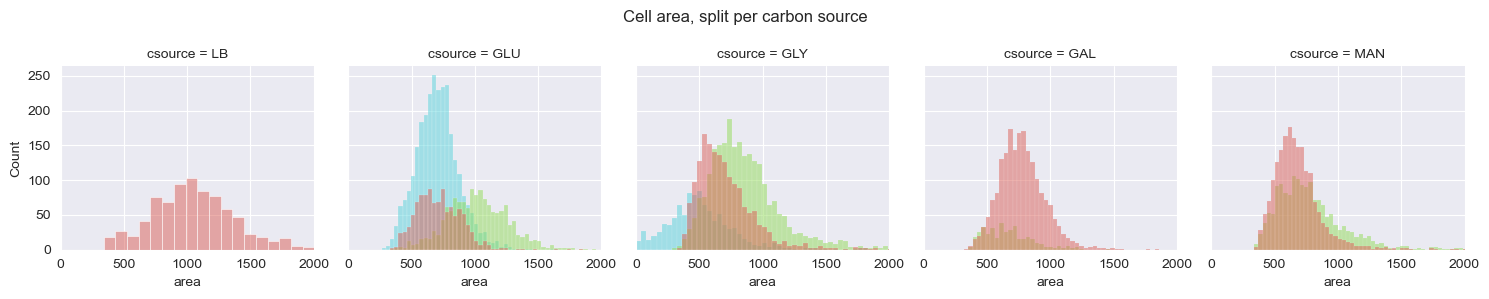

In [724]:
with io.capture_output() as captured:
    g = sns.FacetGrid(df_records, col='csource', col_order=csources_ordered)
    g.map_dataframe(sns.histplot, x='area', hue='replicate', stat='count', palette=palette_replicate)
    g.set(xlim=(0, 2000))
    g.fig.suptitle('Cell area, split per carbon source')
    g.tight_layout();

log(area) = f(mu)

#### Eccentricity

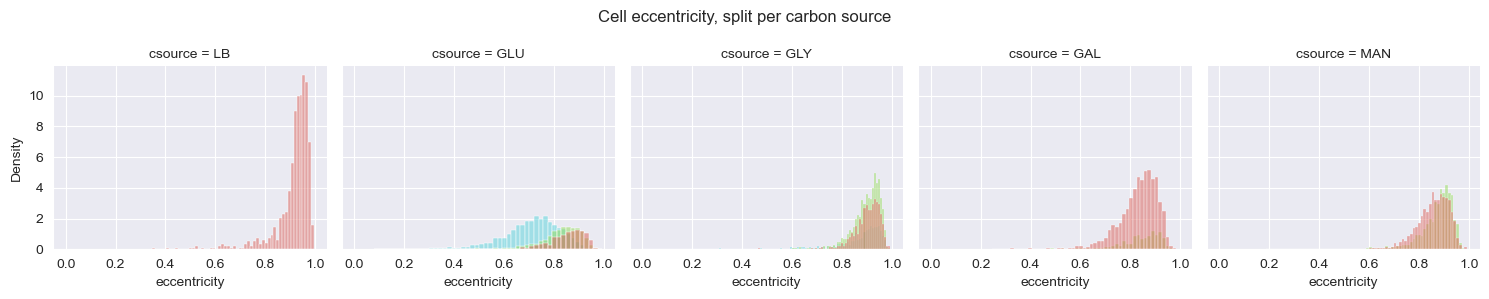

In [641]:
with io.capture_output() as captured:
    g = sns.FacetGrid(df_records, col='csource', col_order=csources_ordered)
    g.map_dataframe(sns.histplot, x='eccentricity', hue='replicate', stat='density', palette=palette_replicate)
    g.fig.suptitle('Cell eccentricity, split per carbon source')
    g.tight_layout();

#### Distance of spots to cell centroid/closest cell tip
 

#### Distance of spots to cell mask

#### Distance of spots to closest nucleoid tip

#### Distance of spots to nuclei


### Number of spots per cell

#### Average per image

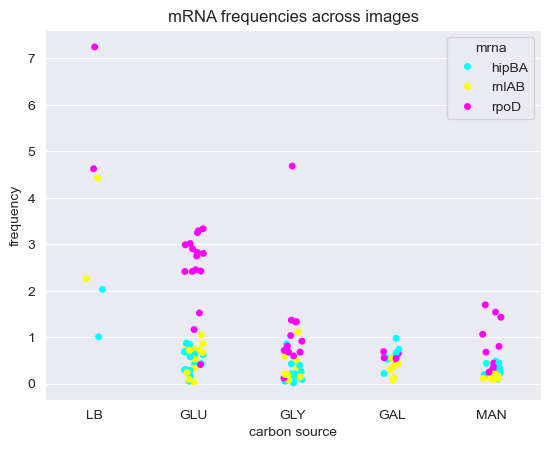

In [642]:
g = sns.stripplot(frequencies, x='csource', order=csources_ordered, y='frequencies', hue='mrna', palette=palette_mrna)
g.set(title='mRNA frequencies across images', xlabel='carbon source', ylabel='frequency');
# numbers need to be consistent across images within one condition

#### Distributions
Cell expression histograms per csource per mRNA = 
#spots/cell for csource, aggregated over all images for csource

[TODO] add the mean


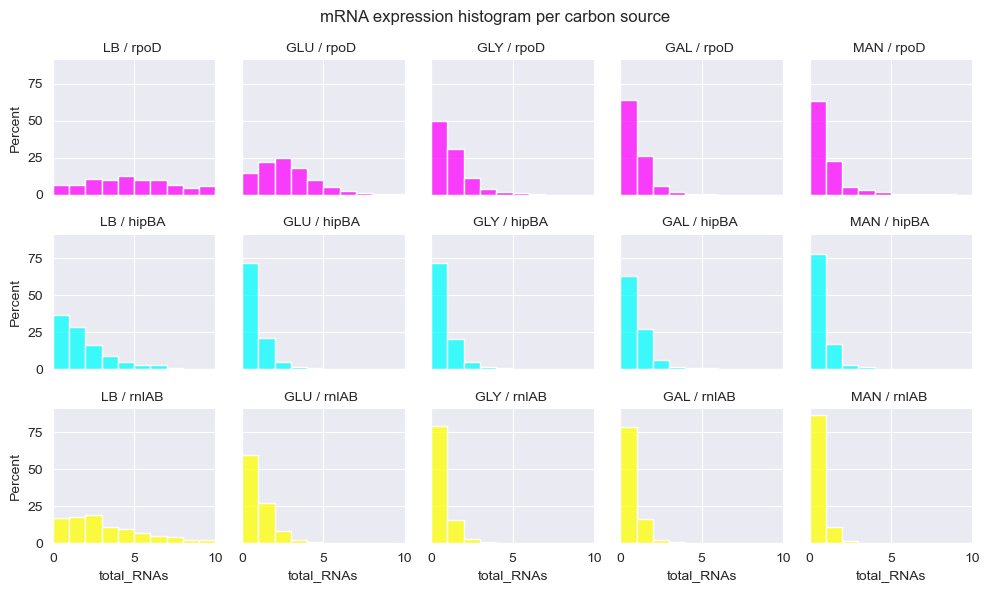

In [643]:
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

In [645]:
df_records_sane = df_records.query('total_RNAs_rpoD < 20').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')
df_stacked_sane = df_stacked.query('total_RNAs < 20')

### Co-expression

#### 2D histograms

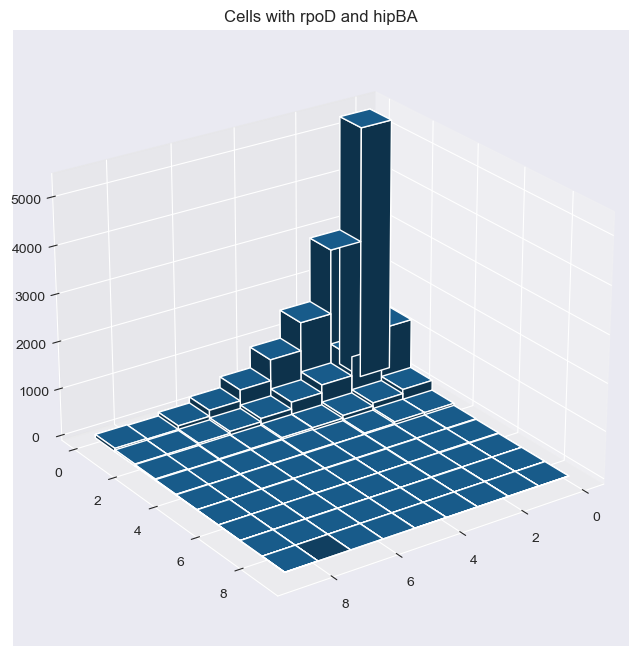

In [646]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
x, y = df_records_sane['total_RNAs_rpoD'], df_records_sane['total_RNAs_hipBA']
hist, xedges, yedges = np.histogram2d(y, x, bins=9, range=[[0, 9], [0, 9]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="xy")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 1
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.view_init(25, 55)
plt.title("Cells with rpoD and hipBA")
plt.show()

#### Density plots

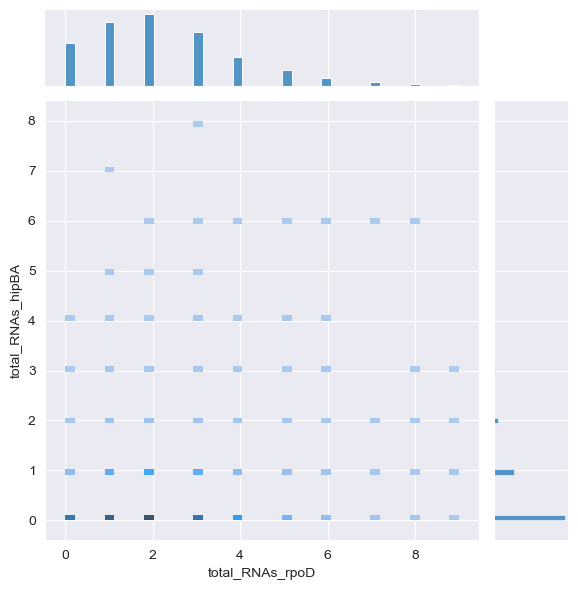

In [647]:
df_records_sane = df_records.query('total_RNAs_rpoD < 10').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')
sns.jointplot(data=df_records_sane.query('csource == "GLU"'), x='total_RNAs_rpoD', y='total_RNAs_hipBA', kind='hist');
# sns.kdeplot(data=df_records_sane.query('csource == "GLU"'), x='total_RNAs_rpoD', y='total_RNAs_hipBA', fill=False, levels=10, color="#4CB391");

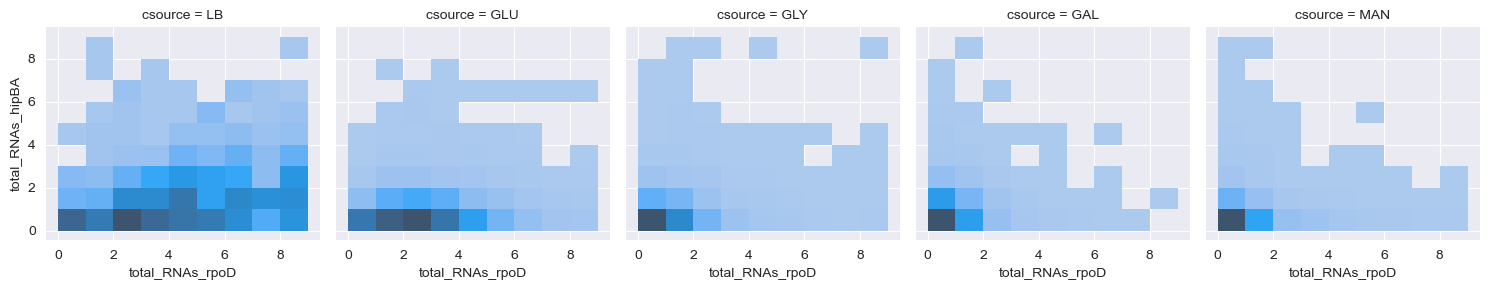

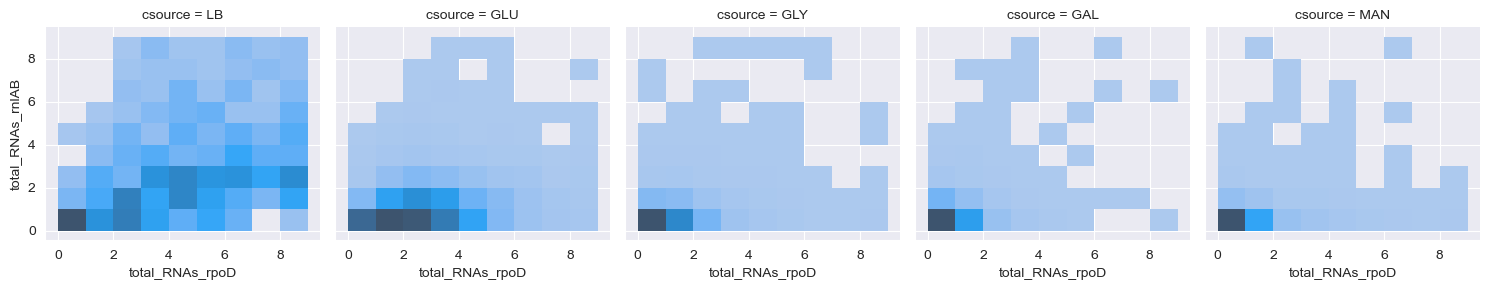

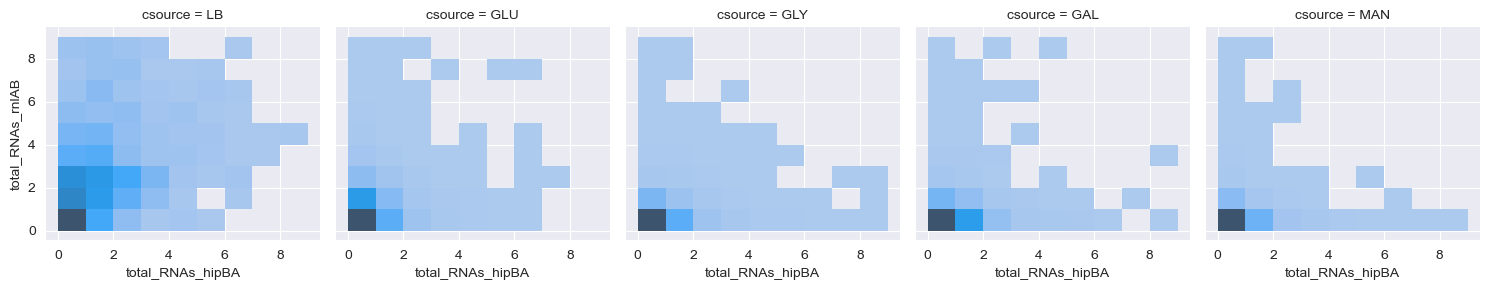

In [653]:
fill=True
g1 =sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g1.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_hipBA', binwidth=1)
# g1.map_dataframe(sns.kdeplot, x='total_RNAs_rpoD', y='total_RNAs_hipBA', color="#4CB391", fill=fill)

g2 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g2.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_rnlAB', binwidth=1)
# g2.map_dataframe(sns.kdeplot, x='total_RNAs_rpoD', y='total_RNAs_rnlAB', color="#4CB391", fill=fill)

g3 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g3.map_dataframe(sns.histplot, x='total_RNAs_hipBA', y='total_RNAs_rnlAB', binwidth=1)
# g3.map_dataframe(sns.kdeplot, x='total_RNAs_hipBA', y='total_RNAs_rnlAB', color="#4CB391", fill=fill);

#### Fraction of cells with two RNAs

In [654]:
#  same content as cell below, just easier to check
df_counts = pd.DataFrame({
    'total': df_records.groupby('csource').size().reindex(csources_ordered),
    'rpoD': df_records.query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB': df_records.query('spots_rnlAB > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA': df_records.query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&hipBA': df_records.query('spots_rnlAB > 0').query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&rpoD': df_records.query('spots_rnlAB > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA&rpoD': df_records.query('spots_hipBA > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
})

df_counts['%rpoD'] = df_counts['rpoD'] / df_counts['total']
df_counts['%rnlAB'] = df_counts['rnlAB'] / df_counts['total']
df_counts['%hipBA'] = df_counts['hipBA'] / df_counts['total']
df_counts['%rnlAB*%hipBA'] = df_counts['%rnlAB'] * df_counts['%hipBA']
df_counts['%rnlAB&hipBA'] = df_counts['rnlAB&hipBA'] / df_counts['total']
df_counts['%rnlAB&rpoD'] = df_counts['rnlAB&rpoD'] / df_counts['total']
df_counts['%hipBA&rpoD'] = df_counts['hipBA&rpoD'] / df_counts['total']
# df_counts = df_counts[['total', 'rpoD', '%rpoD', 'hipBA', '%hipBA', 'rnlAB', '%rnlAB', '%rnlAB*%hipBA', '%rnlAB&hipBA', '%rnlAB&rpoD', '%hipBA&rpoD']]
df_counts

,total,rpoD,rnlAB,hipBA,rnlAB&hipBA,rnlAB&rpoD,hipBA&rpoD,%rpoD,%rnlAB,%hipBA,%rnlAB*%hipBA,%rnlAB&hipBA,%rnlAB&rpoD,%hipBA&rpoD
csource,,,,,,,,,,,,,,
LB,813,758,671,517,470,659,500,0.93,0.83,0.64,0.52,0.58,0.81,0.62
GLU,5284,4503,2111,1477,690,1972,1350,0.85,0.40,0.28,0.11,0.13,0.37,0.26
GLY,5084,2536,1061,1438,421,693,827,0.50,0.21,0.28,0.06,0.08,0.14,0.16
GAL,2348,842,502,864,221,227,334,0.36,0.21,0.37,0.08,0.09,0.10,0.14
MAN,3523,1286,472,774,113,255,296,0.37,0.13,0.22,0.03,0.03,0.07,0.08


In [655]:
all_frequencies = pd.DataFrame()

total_cells = df_records.groupby('csource').size().reindex(csources_ordered)

for mrna in ['rpoD', 'rnlAB', 'hipBA']:
    df_mrna = pd.DataFrame({'counts': df_records.query(f'spots_{mrna} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna
    df_mrna['cardinality'] = 1
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 2):
    df_mrna = pd.DataFrame({'counts': df_records.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1]
    df_mrna['cardinality'] = 2
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 3):
    df_mrna = pd.DataFrame({'counts': df_records.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').query(f'spots_{mrna_pair[2]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1] + '_' + mrna_pair[2]
    df_mrna['cardinality'] = 3
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[2]')['fraction']

    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
all_frequencies

,counts,mrna_set,cardinality,total,fraction,expected
csource,,,,,,
LB,758,rpoD,1,813,0.93,NaN
GLU,4503,rpoD,1,5284,0.85,NaN
GLY,2536,rpoD,1,5084,0.50,NaN
GAL,842,rpoD,1,2348,0.36,NaN
MAN,1286,rpoD,1,3523,0.37,NaN
LB,671,rnlAB,1,813,0.83,NaN
GLU,2111,rnlAB,1,5284,0.40,NaN
GLY,1061,rnlAB,1,5084,0.21,NaN
GAL,502,rnlAB,1,2348,0.21,NaN


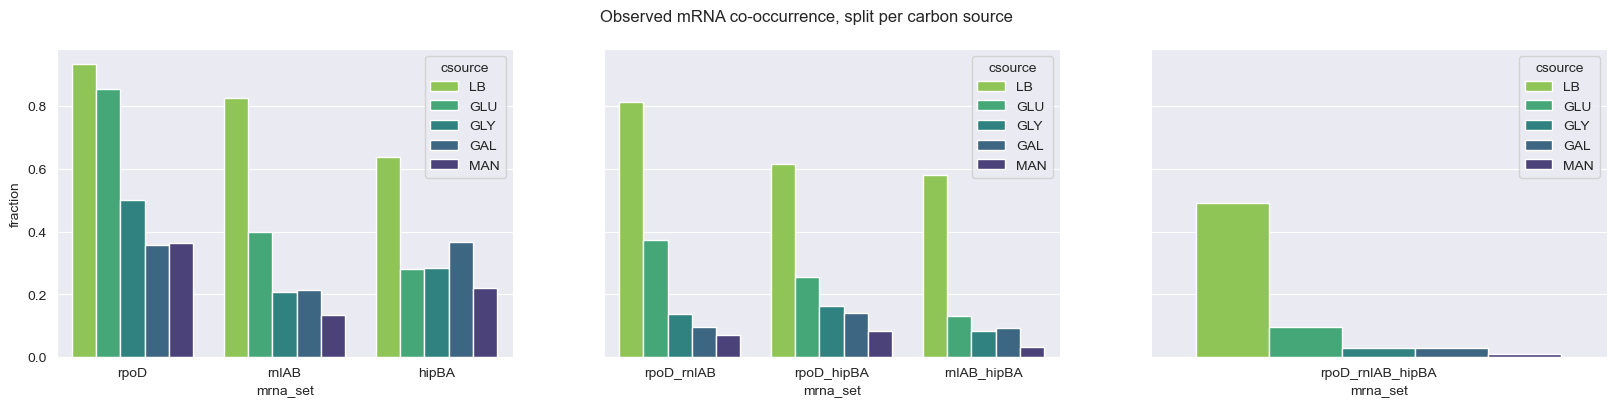

In [656]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence, split per carbon source')

g = sns.barplot(all_frequencies.query('cardinality == 1'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 3'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2])

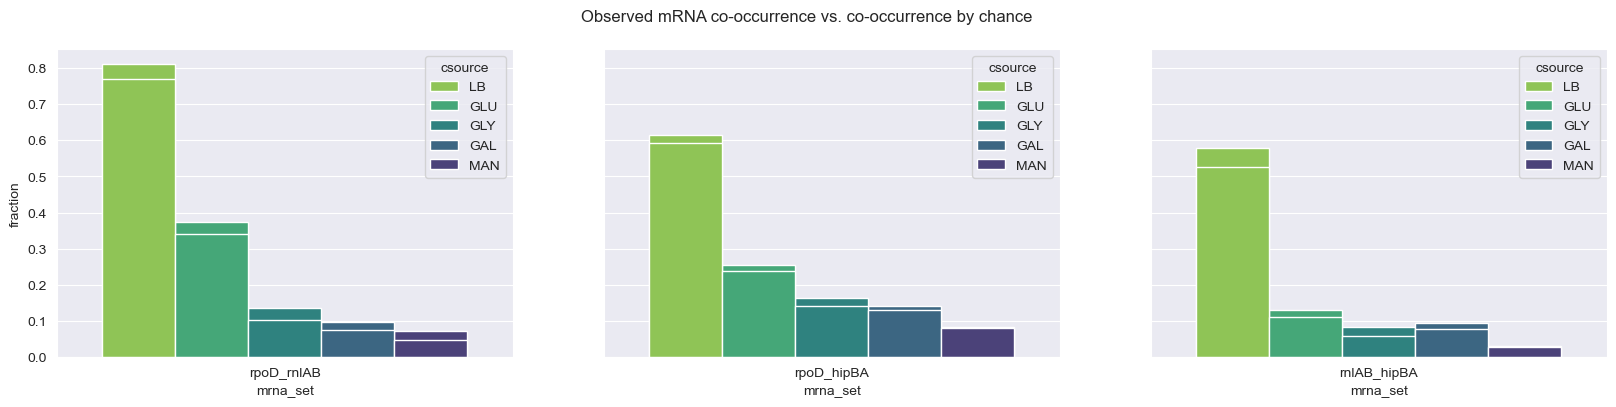

In [657]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2], legend=False)

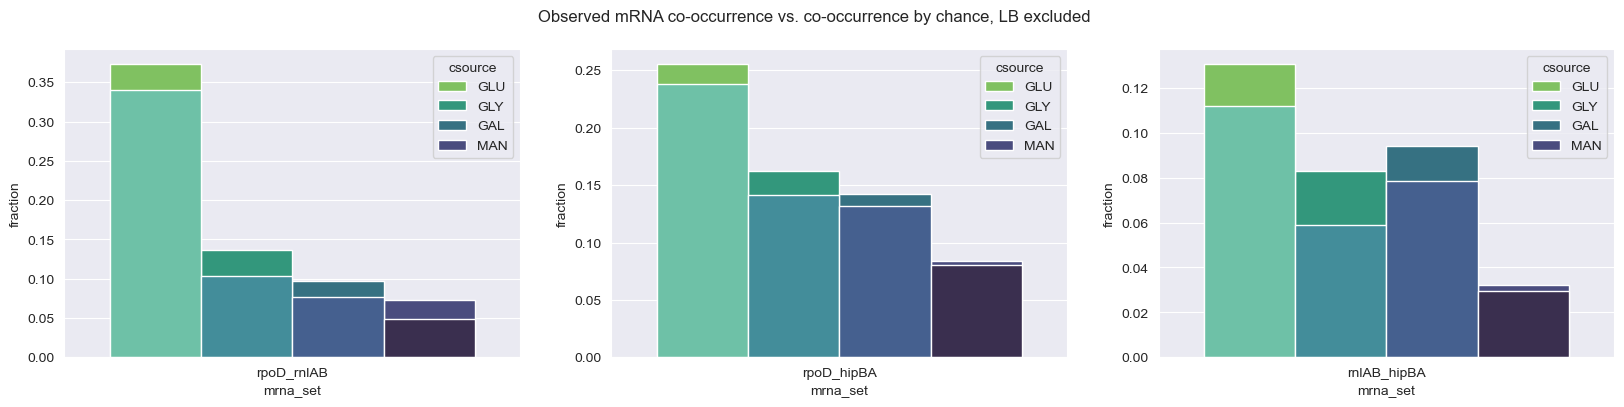

In [658]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance, LB excluded')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[2], legend=False)

#### Area and eccentricity of cells with both RNAs

### Expression versus cell features

In [659]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'nuclei', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected'],
      dtype='object')

In [660]:
df_records.columns

Index(['image_cell_id', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'nuclei', 'spots_hipBA', 'dense_regions_hipBA',
       'decomposed_RNAs_hipBA', 'tx_hipBA', 'nascent_RNAs_hipBA',
       'total_RNAs_hipBA', 'spots_rnlAB', 'dense_regions_rnlAB',
       'decomposed_RNAs_rnlAB', 'tx_rnlAB', 'nascent_RNAs_rnlAB',
       'total_RNAs_rnlAB', 'spots_rpoD', 'dense_regions_rpoD',
       'decomposed_RNAs_rpoD', 'tx_rpoD', 'nascent_RNAs_rpoD',
       'total_RNAs_rpoD', 'strain', 'condition', 'seqnr', 'image',
       'experiment', 'csource', 'coverslip', 'replicate', 'unique_cell_id',
       'selected'],
      dtype='object')

#### Area

In [670]:
df_stacked_sane.dtypes

image_cell_id        int64
spots                int64
dense_regions        int64
decomposed_RNAs      int64
tx                   int64
nascent_RNAs         int64
total_RNAs           int64
mrna                object
strain              object
condition           object
seqnr               object
image               object
experiment          object
bbox-0               int64
bbox-1               int64
bbox-2               int64
bbox-3               int64
area               float64
eccentricity       float64
nuclei               int64
csource             object
coverslip           object
replicate           object
unique_cell_id      object
selected              bool
dtype: object

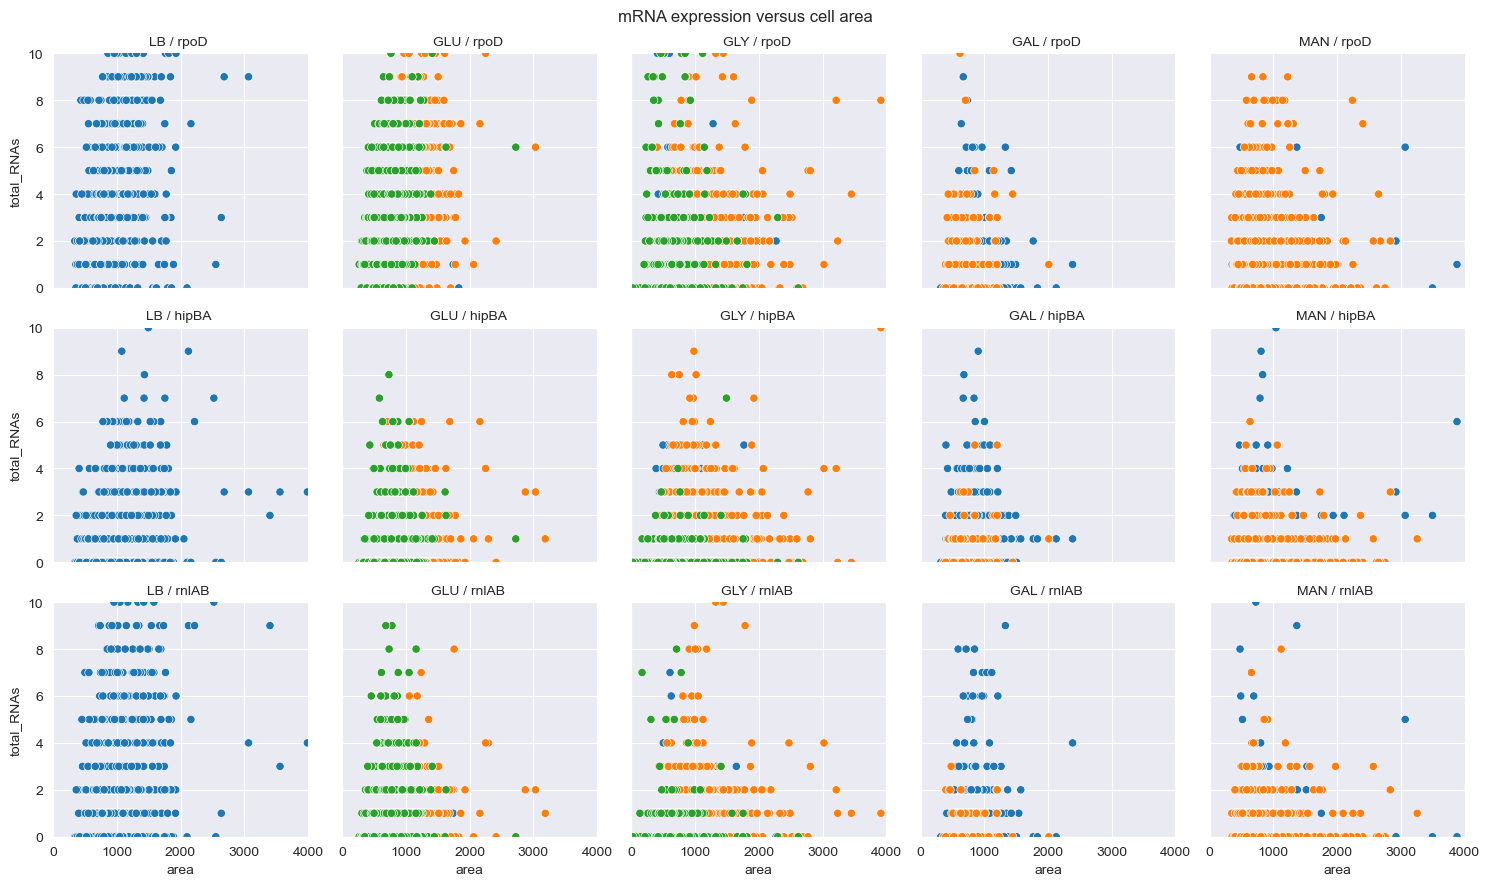

In [676]:
g = sns.FacetGrid(df_stacked_sane, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered,
                  ylim=(0, 10), xlim=(0, 4000), sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, y='total_RNAs', x='area', hue='replicate')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

#### Eccentricity

#### Counts vs growth rate


## Transcription sites

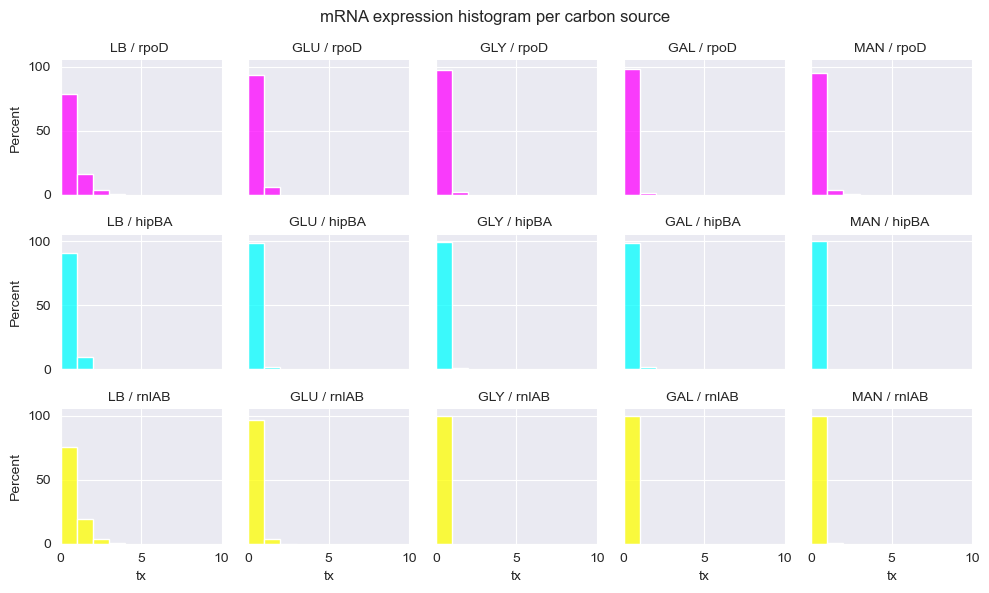

In [671]:
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='tx', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();


## Inspect images individually

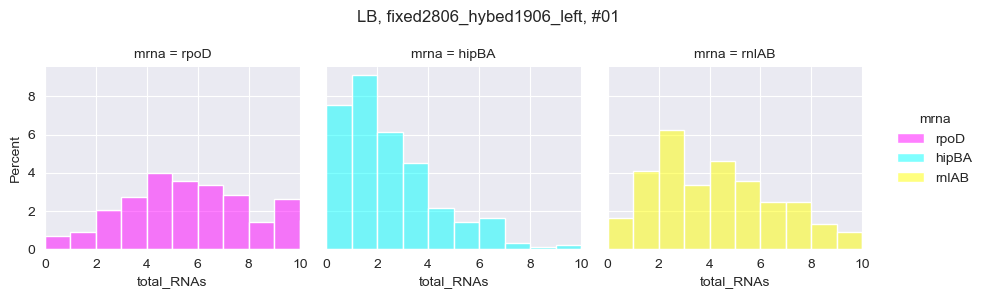

In [672]:
image = 'MG1655_LB_fixed2806_hybed1906_left_01'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

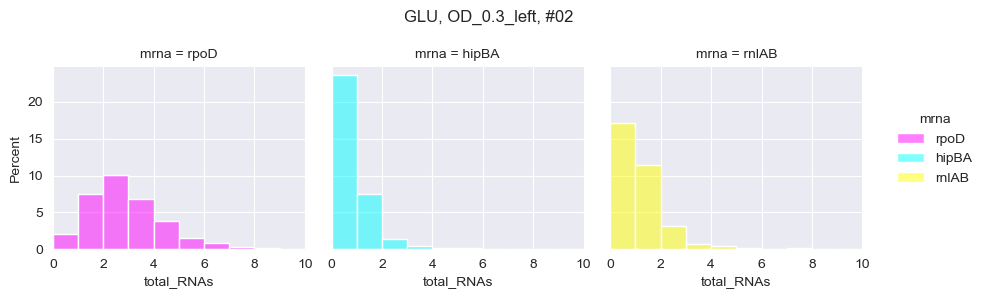

In [673]:
image = 'MG1655_GLU_OD_0.3_left_02'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

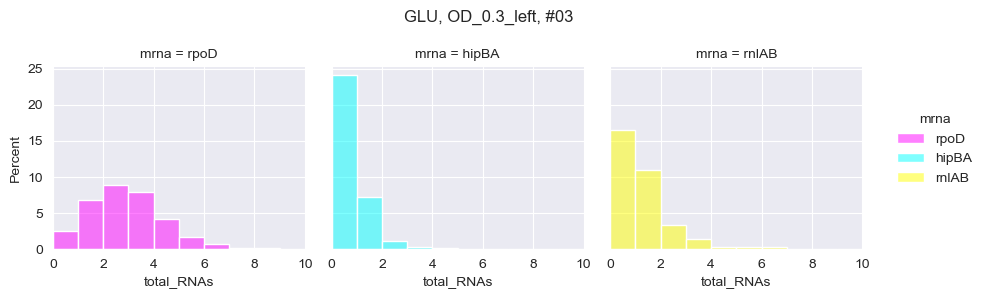

In [674]:
image = 'MG1655_GLU_OD_0.3_left_03'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

## Spot intensity histograms
Spots in cells versus spots outside cells

See `intensities.ipynb` notebook.